<a href="https://colab.research.google.com/github/harshit1441/CV/blob/main/Copy_of_CV_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment - 3**
## **Fine-tuning a Pretrained ResNet Model for Image Classification**

In this assignment, we will explore the concept of transfer learning by fine-tuning a pretrained ResNet model for the task of image classification. ResNet, or Residual Network, is a deep convolutional neural network architecture that has achieved state-of-the-art performance on a variety of visual recognition tasks. Pretrained models are models that have been previously trained on large datasets, such as ImageNet, and can serve as a starting point for new tasks by leveraging learned features. By fine-tuning the pretrained ResNet, we aim to adapt its feature representations to a new dataset, improving both training efficiency and model performance. This process involves adjusting the model’s final layers to suit the specific classification problem, while retaining the learned features from earlier layers. At the end we compare the prformance of the pre-trained model with that of the fine-tuned model.

====================================================================================================

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 1**
1) <blue>**torch**</blue>: This imports the <green>**PyTorch library**</green>, which is essential for building and training neural networks.
2) <blue>**torch.nn**</blue>: Imports the <green>**neural network module**</green> of PyTorch, which contains various layers and loss functions used to build models.
3) <blue>**torch.optim**</blue>: This imports the <green>**optimization algorithms**</green> module, used for updating the model's weights based on the computed gradients during training.
4) <blue>**torchvision -> datasets, models, transforms**</blue>: Imports functions from <green>**Torchvision**</green> for accessing popular datasets, pre-trained models, and transformations for image preprocessing.
5) <blue>**torchvision.utils -> make_grid**</blue>: This function is used to <green>**visualize multiple images**</green> in a grid format, useful for displaying image batches.
6) <blue>**torch.utils.data -> DataLoader**</blue>: Imports the <green>**DataLoader**</green> class, which allows for efficient loading and batching of datasets during training and testing.
7) <blue>**matplotlib.pyplot**</blue>: This imports <green>**Matplotlib**</green>, which is used for plotting and visualizing images or training metrics such as loss and accuracy.
8) <blue>**numpy**</blue>: Imports <green>**NumPy**</green> for handling arrays and performing numerical operations, which are often useful in preprocessing and analyzing data.
9) <blue>**time**</blue>: This allows tracking <green>**elapsed time**</green> during the training process, often used to measure performance.
10) <blue>**os**</blue>: Imports <green>**OS module**</green> to handle tasks like creating directories, managing file paths, or interacting with the file system.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 2**
1) <blue>**device**</blue>: This variable checks if a <green>**CUDA-capable GPU**</green> is available; if so, it sets the device to GPU (cuda), otherwise, it falls back to the <green>**CPU**</green>.
2) <blue>**transforms.Compose**</blue>: This creates a series of <green>**transformations for training images**</green>, applied in the specified order to augment the data and prepare it for the model.
3) <blue>**transforms.Grayscale(num_output_channels=3)**</blue>: This transformation converts input images from grayscale to <green>**RGB**</green> by creating 3 output channels, which is necessary for models expecting RGB inputs.
4) <blue>**transforms.RandomResizedCrop(224)**</blue>: This randomly crops the input image to a size of <green>**224x224 pixels**</green>, introducing variation in the training data to improve model generalization.
5) <blue>**transforms.RandomHorizontalFlip()**</blue>: This randomly flips the image horizontally with a 50% chance, providing additional <green>**data augmentation**</green> for the training dataset.
6) <blue>**transforms.ToTensor()**</blue>: Converts the PIL image or NumPy array into a <green>**PyTorch tensor**</green>, which is the required input format for models.
7) <blue>**transforms.Normalize()**</blue>: This normalizes the tensor with mean and standard deviation values specified for each channel, helping the model to <green>**converge faster**</green> and perform better by ensuring the input data has a consistent scale.
8) <blue>**transforms.Resize(256)**</blue>: This resizes the input image to a height and width of <green>**256 pixels**</green>, ensuring consistency in input size before cropping.
9) <blue>**transforms.CenterCrop(224)**</blue>: This crops the center of the image to <green>**224x224 pixels**</green>, focusing on the most important part of the image for testing.

In [8]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for training and testing
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 3**
1) This code outlines loading the <blue>**Caltech-256**</blue> dataset for <green>**image classification**</green>.
2) The <blue>**train_loader**</blue> and <blue>**test_loader**</blue> are used to load the datasets in batches of 32, with shuffling applied only to the training set.

Note: The placeholders **"None"** need to be replaced with the correct dataset-loading code.

In [12]:
import kagglehub
import shutil, random

# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")
print(path)

Using Colab cache for faster access to the 'caltech256' dataset.
/kaggle/input/caltech256


In [14]:
dir= f"{path}/split_data"

base_dir = f"{path}/256_ObjectCategories"
target_dir = "/kaggle/working/split_data"

os.makedirs(f"{target_dir}/train", exist_ok=True)
os.makedirs(f"{target_dir}/test", exist_ok=True)

for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if not os.path.isdir(category_path):
        continue

    images = os.listdir(category_path)
    random.shuffle(images)

    split = int(0.8 * len(images))
    train_imgs = images[:split]
    test_imgs = images[split:]

    os.makedirs(f"{target_dir}/train/{category}", exist_ok=True)
    os.makedirs(f"{target_dir}/test/{category}", exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(category_path, img), f"{target_dir}/train/{category}/{img}")
    for img in test_imgs:
        shutil.copy(os.path.join(category_path, img), f"{target_dir}/test/{category}/{img}")

print("✅ Done splitting data into train/test folders!")


✅ Done splitting data into train/test folders!


In [15]:
# TODO: Use Caltech-256 dataset, you can download and load it through torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(root= f"{target_dir}/train", transform=transform_train)  # Replace None with code to load the dataset with training transformations defined above
test_dataset = datasets.ImageFolder(root= f"{target_dir}/test", transform=transform_test)  # Replace None with code to load the dataset with test transformations defined above

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 4**
1) <blue>**model = None**</blue>: This line will load a <green>**pre-trained ResNet-18 model**</green> from the Torchvision library, which has been trained on the ImageNet dataset, allowing for transfer learning, when None is replaced with proper code.
2) <blue>**for param in model.parameters()**:</blue>: This loop iterates over all the parameters of the model, enabling modifications to their properties.
3) <blue>**param.requires_grad = None**</blue>: Inside the loop, this line will be used to <green>**freeze the model weights**</green> for all layers except the final fully connected layer. By setting requires_grad to False, gradients will not be calculated for these parameters during backpropagation, preventing them from being updated during training, when None is replace by proper code
4) <blue>**num_ftrs = model.fc.in_features**</blue>: This line retrieves the number of input features from the final fully connected layer of the model, which is necessary for modifying that layer.
5) <blue>**model.fc = nn.Linear(num_ftrs, 257)**</blue>: This modifies the final fully connected layer to output <green>**257 classes**</green>, corresponding to the number of classes in the Caltech-256 dataset, replacing the original output layer.

Note: The placeholders **"None"** need to be replaced with the correct code.

In [16]:
# TODO: Replace None with correct code for loading a pretrained Resnet-18 model
model = models.resnet18(pretrained=True)

# Freeze the model weights except for the final layer
for param in model.parameters():
    # TODO: Freeze the model weights
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 257)  # 257 classes in Caltech-256

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 5**
1) <blue>**model = None**</blue>: This line sends the <green>**model to the appropriate device**</green>, whether it's a GPU (if available) or a CPU, ensuring that the computations happen on the selected hardware, when None is replace with correct code.
2) <blue>**criterion = None**</blue>: Defines the <green>**loss function**</green> as cross-entropy loss, which is commonly used for multi-class classification problems, when None is replaced with the correct code.
3) <blue>**optimizer = None**</blue>: Initialize the <green>**Adam optimizer**</green> to update only the parameters of the modified final layer (model.fc). Set the learning rate to <green>**0.001**</green> to control the step size for each update during training.

Note: The placeholders **"None"** need to be replaced with the correct code.


In [17]:
# TODO: Replace None with correct code to send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

# Define loss function and optimizer
# TODO: Use a suitable loss criterion and optimizer with learning rate 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

cuda:0


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 6**
1) <blue>**train_model**</blue>: This function trains and evaluates the model for a specified number of <green>**epochs**</green>.
2) It <green>**alternates**</green> between training and testing phases, setting the model to <blue>**train() or eval()**</blue> mode accordingly.
3) <blue>**images = None, labels = None**</blue>: Images and labels are moved to the <green>**device (CPU or GPU)**</green>.
4) <blue>**Backpropagation and Optimization**</blue>: Gradients are calculated using backpropagation, and the optimizer <green>**updates the model parameters**</green> based on these gradients.

Note: The placeholders **"None"** need to be replaced with the correct code.


In [18]:
# Train and evaluate the model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                # ✅ Move both to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)   # ✅ pass GPU tensor
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model


# ✅ Confirm model device
print(next(model.parameters()).device)

# Fine-tune the model
fine_tuned_model = train_model(model, criterion, optimizer, num_epochs=5)

cuda:0
Epoch 0/4
----------
train Loss: 3.0624 Acc: 0.3939
test Loss: 1.5097 Acc: 0.6586
Epoch 1/4
----------
train Loss: 1.8308 Acc: 0.5870
test Loss: 1.2976 Acc: 0.6864
Epoch 2/4
----------
train Loss: 1.6412 Acc: 0.6142
test Loss: 1.2386 Acc: 0.6937
Epoch 3/4
----------
train Loss: 1.5373 Acc: 0.6361
test Loss: 1.1814 Acc: 0.7118
Epoch 4/4
----------
train Loss: 1.4894 Acc: 0.6465
test Loss: 1.1527 Acc: 0.7197


<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 7**
The provided code consists of three functions designed for model evaluation and visualization:
1) <blue>**visualize_predictions**</blue>: This function takes a <green>**trained model**</green> and a <green>**dataloader**</green>, then displays a set number of images with their predicted labels. It sets the model to <blue>**evaluation mode**</blue> and processes the input data without <green>**calculating gradients**</green> (using <blue>**torch.no_grad()**</blue>), which speeds up the evaluation. After moving the inputs to the correct device, it computes predictions using a forward pass through the model and visualizes the results in a subplot.
2) <blue>**denormalize**</blue>: This utility function converts a <blue>**normalized image tensor**</blue> back to its <blue>**original form**</blue> by <green>**reversing the normalization process**</green>. It applies the <green>**mean**</green> and <green>**standard deviation**</green> used during image preprocessing, ensuring the values are scaled back into the range suitable for visualization (<blue>**clipped between 0 and 1**</blue>).
3) <blue>**make_map_classes**</blue>: This function generates a <blue>**dictionary mapping class indices**</blue> to their corresponding class names. It reads the folder names (assuming they follow a specific naming convention), extracts the index and name of each class, and sorts them in the correct order for use in classification tasks.

In [19]:
# Evaluate the performance of the model before and after fine-tuning
# Function to visualize images and their predictions
def visualize_predictions(model, dataloader, num_images=2):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloader:
            # TODO: Move images to the device
            inputs = inputs.to(device)

            # TODO: Forward Pass = Get Predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[i].item()}')
                img = inputs.cpu().data[i]
                img = img.permute(1, 2, 0).numpy()  # Convert from Tensor format
                img = np.clip(img, 0, 1)  # Clip the values for display
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Function to denormalize the image for visualization
def denormalize(image_tensor):
    # Means and stds used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert tensor to HWC
    image = std * image + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip values to be in [0, 1] range
    return image


def make_map_classes(path):
    classes_dir = os.listdir(path)
    classes_dir.sort()
    classes_dict = {}
    for c in classes_dir:
        index = int(c[:3])
        name = c[4:]
        classes_dict[index] = name

    return classes_dict

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 8**
1) This function, <blue>**compare_predictions**</blue>, is designed to visually compare the predictions made by a <green>**pre-trained model**</green> and a <green>**fine-tuned version**</green> of that model, helping to assess the impact of fine-tuning. It takes in both models, a dataloader, the directory path containing class labels, and the number of images to display.
2) <blue>**Model Evaluation Mode**</blue>: Both the <green>**pre-trained**</green> and <green>**fine-tuned models**</green> are set to <green>**evaluation mode**</green> using <blue>**.eval()**</blue>. This ensures that no gradients are calculated during the forward pass, making inference faster and memory-efficient.
3)  The TODO lines highlight the need to move the <blue>**input images (inputs)**</blue> to the appropriate device (<green>**CPU**</green> or <green>**GPU**</green>), though this is left as an implementation detail.
4) The first subplot shows the prediction from the <blue>**pre-trained model**</blue> along with its <green>**corresponding class name (retrieved from**</green> the <blue>**classes_dict dictionary**</blue>). The second subplot shows the prediction from the <blue>**fine-tuned model**</blue> for comparison. This allows easy visual inspection of how fine-tuning has affected the model's ability to make accurate predictions.

In [20]:
# Function to compare predictions of non-finetuned and finetuned models
def compare_predictions(pretrained_model, finetuned_model, dataloader, path_dir, num_images=5):
    pretrained_model.eval()
    finetuned_model.eval()

    images_shown = 0
    classes_dict = make_map_classes(path_dir)

    with torch.no_grad():
        for inputs, labels in dataloader:
            # TODO: Move inputs to device
            inputs = inputs.to(device)

            # Predictions from pre-trained model (without fine-tuning)
            # TODO: Calculate outputs using forward pass of pretrained model
            pre_outputs = pretrained_model(inputs)
            _, pre_preds = torch.max(pre_outputs, 1)

            # Predictions from fine-tuned model
            # TODO: Calculate the outputs using the gforward pass of the finetuned model
            fin_outputs = finetuned_model(inputs)
            _, fin_preds = torch.max(fin_outputs, 1)

            for i in range(inputs.size()[0]):
                if images_shown == num_images:
                    return  # Stop after showing num_images
                images_shown += 1

                img = denormalize(inputs.cpu().data[i])

                plt.figure(figsize=(10, 4))

                # Show pre-trained model's prediction
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f'Pre-trained Prediction: {pre_preds[i].item()} : {classes_dict[pre_preds[i].item()]}')
                plt.axis('off')

                # Show fine-tuned model's prediction
                plt.subplot(1, 2, 2)
                plt.imshow(img)
                plt.title(f'Fine-tuned Prediction: {fin_preds[i].item()} : {classes_dict[fin_preds[i].item()+1]}')
                plt.axis('off')

                plt.show()

<style>
blue {
  color: skyblue;
}

red {
  color: red;
}

green {
  color: lightgreen;
}
</style>

### **Step - 9**
This code snippet is used to <green>**evaluate**</green> and visualize the predictions of both a <blue>**pre-trained**</blue> and a <blue>**fine-tuned model**</blue> on a set of example images. It compares the predictions side by side to assess the <green>**performance improvements**</green> brought by fine-tuning.

Comparing predictions of pre-trained and fine-tuned models on example images...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


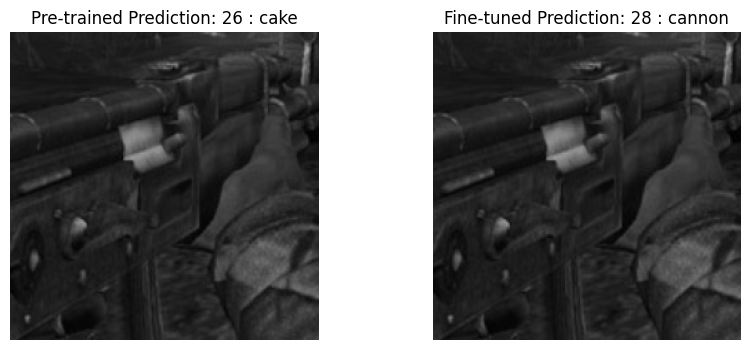

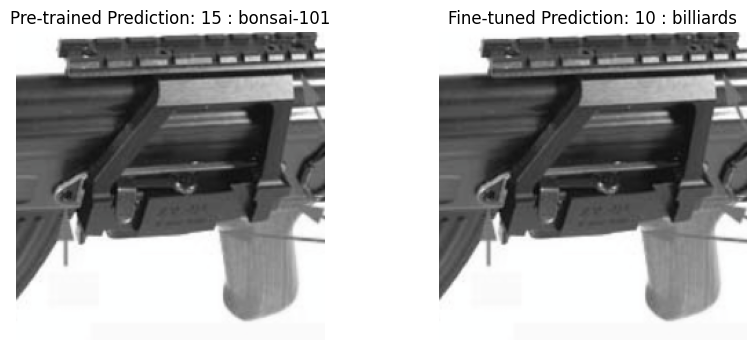

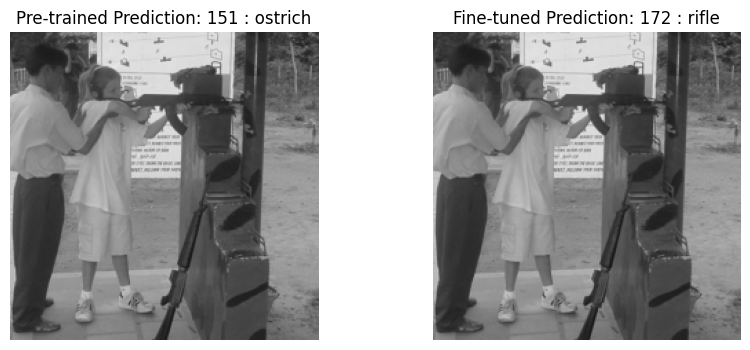

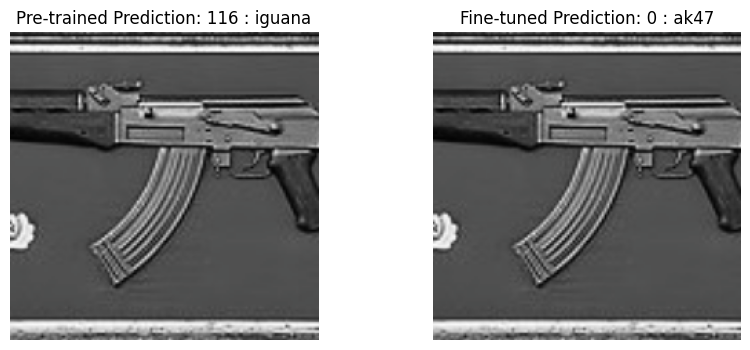

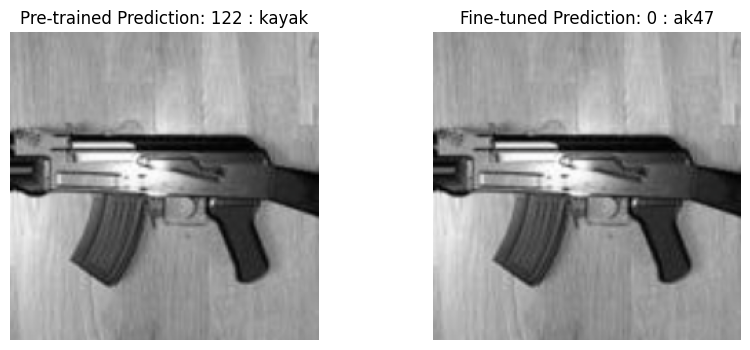

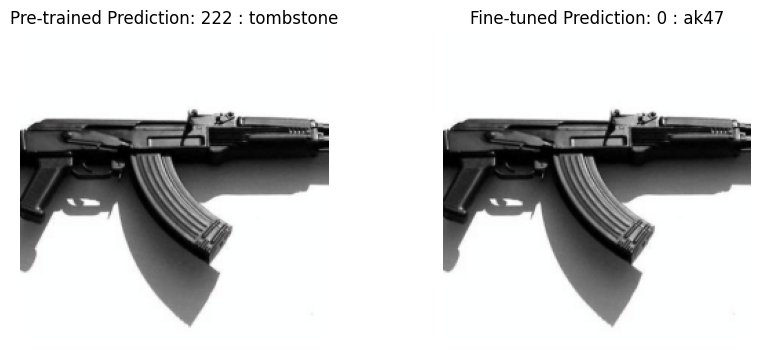

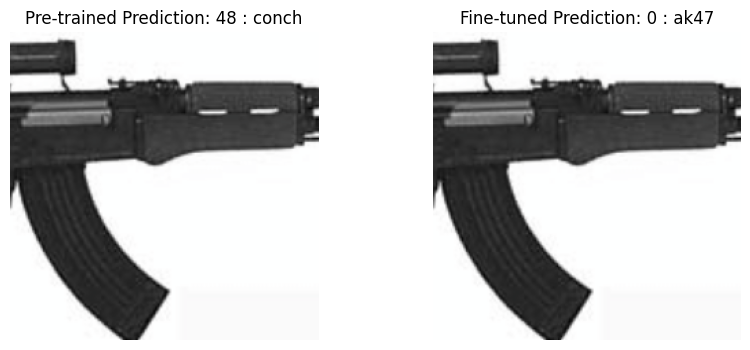

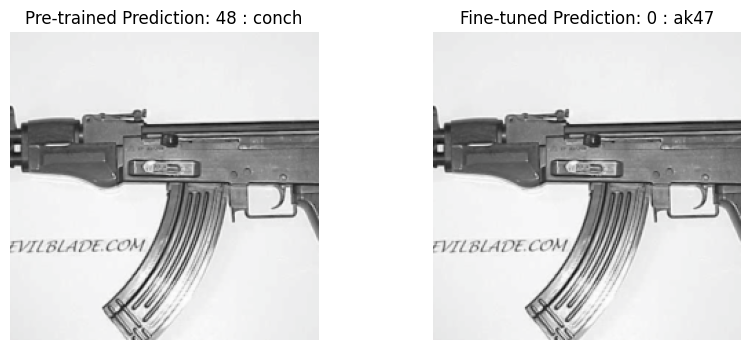

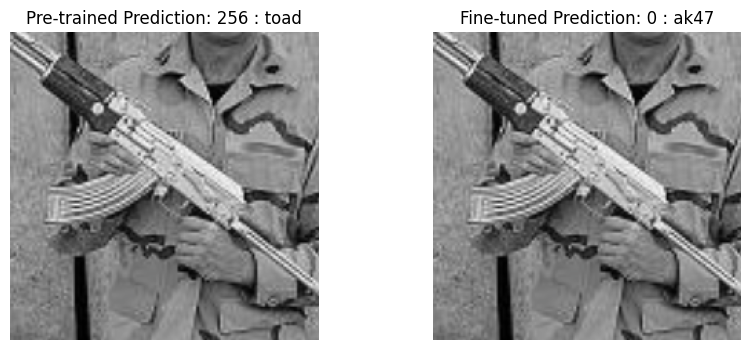

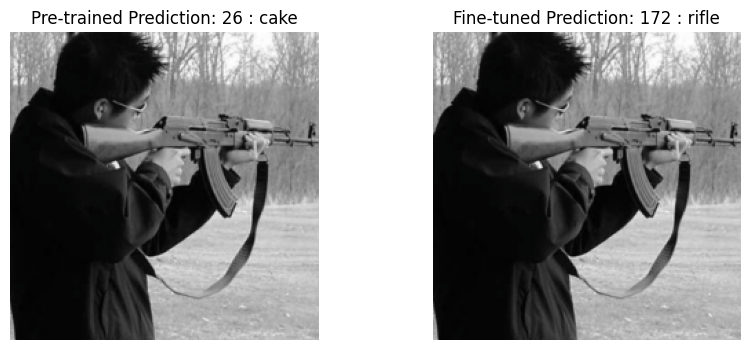

In [22]:
# Evaluate and visualize predictions
print("Comparing predictions of pre-trained and fine-tuned models on example images...")

# Ensure both models have the same structure (so, freeze layers for pretrained_model)
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 257)
pretrained_model = pretrained_model.to(device)

# Compare predictions using a couple of test images
# TODO: Fill in the path of the 256_ObjectCategories directory in the path variable below.
path_to256_ObjectCategories_dir = f"{path}/256_ObjectCategories"
compare_predictions(pretrained_model, fine_tuned_model, test_loader, path_to256_ObjectCategories_dir ,num_images=10)


## For students attempting Advanced Level (optional for basic)

### **Step - 10**

#### **Exploring Learning Rate Scheduling and Optimization Strategies**

This step delves deeper into fine-tuning by exploring advanced techniques for optimizing the training process. Instead of using a fixed learning rate, you can implement learning rate scheduling. This involves dynamically adjusting the learning rate during training, which can help the model converge more effectively. Common strategies include step decay, exponential decay, or using reduce-on-LRPatience.

Furthermore, you can experiment with different optimization algorithms beyond Adam, such as SGD with momentum, RMSprop, or even more advanced adaptive optimizers like RAdam or Lookahead. Each optimizer has its own characteristics and can perform differently depending on the dataset and model architecture.

By implementing and comparing various learning rate schedules and optimization strategies, you can gain a deeper understanding of how these factors impact the fine-tuning process and model performance.

In [23]:
# Define a new optimizer (e.g., SGD)
from torch.optim import SGD
new_optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler (e.g., StepLR)
from torch.optim import lr_scheduler
new_scheduler = lr_scheduler.StepLR(new_optimizer, step_size=7, gamma=0.1)

# Modify the train_model function to include the scheduler
def train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running totals
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Epoch statistics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Step the scheduler after each epoch
        scheduler.step()

# Train the model with the new optimizer and scheduler
fine_tuned_model_with_scheduler = train_model_with_scheduler(model, criterion, new_optimizer, new_scheduler, num_epochs=5)


Epoch 0/4
----------
train Loss: 1.2816 Acc: 0.6971
test Loss: 1.0400 Acc: 0.7448
Epoch 1/4
----------
train Loss: 1.2652 Acc: 0.6946
test Loss: 1.0357 Acc: 0.7430
Epoch 2/4
----------
train Loss: 1.2748 Acc: 0.6977
test Loss: 1.0621 Acc: 0.7388
Epoch 3/4
----------
train Loss: 1.2554 Acc: 0.7025
test Loss: 1.0375 Acc: 0.7428
Epoch 4/4
----------
train Loss: 1.2387 Acc: 0.7064
test Loss: 1.0528 Acc: 0.7414


### **Step - 11**

#### **Investigating Different Freezing Strategies and Layer Unfreezing**

In the initial fine-tuning steps, we froze all layers except the final fully connected layer. However, depending on the dataset and the similarity between the pre-training task and the fine-tuning task, you might benefit from unfreezing more layers or using different freezing strategies.

This step encourages you to experiment with unfreezing earlier layers of the pre-trained model. While unfreezing all layers might lead to overfitting on smaller datasets, selectively unfreezing blocks of layers or even individual layers can allow the model to learn more task-specific features from the earlier convolutional layers.

You can also explore gradual unfreezing, where you start by unfreezing only the last few layers and then progressively unfreeze earlier layers as training progresses. This can help stabilize training and prevent catastrophic forgetting of the pre-trained knowledge. By comparing the performance of models fine-tuned with different freezing strategies, you can determine the optimal approach for your specific task.

In [24]:
# Unfreeze the last few layers (e.g., layer4 and the fully connected layer)
def unfreeze_last_layers(model, num_layers_to_unfreeze=2):
    # Unfreeze the fully connected layer (already unfrozen in Step 4, but good to be explicit)
    for param in model.fc.parameters():
        param.requires_grad = True

    # Unfreeze the last 'num_layers_to_unfreeze' convolutional layers
    # ResNet-18 has layers: conv1, layer1, layer2, layer3, layer4, fc
    # We want to unfreeze layer4 and potentially layer3
    unfrozen_layers = [model.layer4, model.layer3] # Add more layers to this list as needed

    for i in range(min(num_layers_to_unfreeze, len(unfrozen_layers))):
        for param in unfrozen_layers[i].parameters():
            param.requires_grad = True

# Unfreeze all layers (use with caution, especially on small datasets)
def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True

# Example usage:
# Assuming 'model' is the pretrained ResNet-18 loaded in Step 4
# First, freeze all layers as in Step 4
# for param in model.parameters():
#     param.requires_grad = False

# Then, choose a strategy:
# unfreeze_last_layers(model, num_layers_to_unfreeze=2) # Unfreeze layer4 and layer3
# OR
# unfreeze_all_layers(model) # Unfreeze all layers

# After unfreezing, you would re-define your optimizer to include the newly unfrozen layers
# new_optimizer_for_unfrozen = optim.Adam(model.parameters(), lr=0.0001) # Lower learning rate is often recommended
# Then train the model again with the new optimizer
# fine_tuned_model_unfrozen = train_model(model, criterion, new_optimizer_for_unfrozen, num_epochs=5)

# You would then evaluate and compare this model's performance as done in Step 9.
# Train and Evaluate the new model on the previously given dataset.

### **Evaluatory Task (For Advanced Level)**

Now that you have explored different optimization strategies, learning rate scheduling, and layer unfreezing techniques, try combining these concepts to train a new model.

1.  **Choose an unfreezing strategy:** Decide which layers you want to unfreeze based on your understanding from Step 11. You can use the provided `unfreeze_last_layers` or `unfreeze_all_layers` functions, or experiment with unfreezing specific layers.
2.  **Select an optimizer and learning rate scheduler:** Choose an optimizer (e.g., SGD, Adam with a different learning rate) and a learning rate scheduler (e.g., StepLR, ReduceLROnPlateau) from Step 10.
3.  **Combine and train:** Integrate your chosen unfreezing strategy, optimizer, and scheduler into a training loop. You can adapt the `train_model_with_scheduler` function provided in Step 10.
4.  **Evaluate and compare:** After training, evaluate the performance of your new model using the `visualize_predictions` and `compare_predictions` functions from Step 7 and 8. Compare its performance to the models trained in the previous steps to see the impact of your chosen techniques.

Experiment with different combinations of unfreezing strategies, optimizers, and schedulers to find the best approach for fine-tuning the ResNet model on the Caltech-256 dataset.

You have to write code in a new code cell with the given modifications and evaluate the model again. You can use the previous format of code written. Also include a short written discussion summarizing your findings.

In [ ]:
# ======================================
# Step 12 – Advanced Fine-Tuning Experiment
# ======================================
from torch.optim import Adam, lr_scheduler

# 1️⃣ Unfreeze deeper layers (layer4 + fc)
def unfreeze_last_layers(model, num_layers_to_unfreeze=2):
    for param in model.fc.parameters():
        param.requires_grad = True
    unfrozen_layers = [model.layer4, model.layer3]
    for i in range(min(num_layers_to_unfreeze, len(unfrozen_layers))):
        for param in unfrozen_layers[i].parameters():
            param.requires_grad = True

# Apply the unfreezing strategy
unfreeze_last_layers(model, num_layers_to_unfreeze=2)

# 2️⃣ Define new optimizer & scheduler
new_optimizer_adv = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
new_scheduler_adv = lr_scheduler.ReduceLROnPlateau(new_optimizer_adv, mode='min', factor=0.1, patience=2)

# 3️⃣ Updated training loop (includes ReduceLROnPlateau)
def train_model_with_plateau_scheduler(model, criterion, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 15)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                scheduler.step(epoch_loss)  # Step scheduler on training loss

    return model


# 4️⃣ Train the model using new strategy
fine_tuned_model_adv = train_model_with_plateau_scheduler(
    model, criterion, new_optimizer_adv, new_scheduler_adv, num_epochs=5
)

# 5️⃣ Evaluate & compare
print("\nEvaluating advanced fine-tuned model...")
compare_predictions(pretrained_model, fine_tuned_model_adv, test_loader, path_to256_ObjectCategories_dir, num_images=6)



Epoch 1/5
---------------
